In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Анализ тональности отзывов на товары Wildberries

# Установка моделей, импорт библиотек

In [17]:
!pip install datasets

In [67]:
!pip install compress-fasttext==0.1.0

  Preparing metadata (setup.py) ... done
  Created wheel for compress-fasttext: filename=compress_fasttext-0.1.0-py3-none-any.whl size=13066 sha256=208fa3965fb4a0f16f404a3ff3542bb2759735f5494e9b194573da5b5bc8e201
  Stored in directory: /root/.cache/pip/wheels/7d/4e/1d/79b6c0b8e9e62ec53a545a2c12452a8dd338228b0abaeb9e65
Successfully built compress-fasttext
  Attempting uninstall: compress-fasttext
    Found existing installation: compress-fasttext 0.1.4
    Uninstalling compress-fasttext-0.1.4:
      Successfully uninstalled compress-fasttext-0.1.4


In [10]:
!pip install emoji==2.10.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
from datasets import load_dataset
from datasets import get_dataset_split_names
from datasets import get_dataset_config_names

In [11]:
import emoji
import os
import re
import numpy as np
import pandas as pd
import random
import time

In [19]:
import nltk
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import wordcloud
from collections import Counter

In [29]:
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Загрузка датасетов

## Загрузка датасета для обучения и оценки моделей.
[Датасет для обучения и оценки - это RuReviews: An Automatically Annotated Sentiment Analysis Dataset for Product Reviews in Russian](https://github.com/sismetanin/rureviews/blob/master/women-clothing-accessories.3-class.balanced.csv)

> @INPROCEEDINGS{Smetanin-SA-2019,
> author={Sergey Smetanin and Michail Komarov},
> booktitle={2019 IEEE 21st Conference on Business Informatics (CBI)},
> title={Sentiment Analysis of Product Reviews in Russian using Convolutional Neural Networks},
> year={2019},
> volume={01},
> number={},
> pages={482-486},
> doi={10.1109/CBI.2019.00062},
> ISSN={2378-1963},
> month={July}


In [30]:
! wget https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv

--2024-02-11 13:10:48--  https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21781685 (21M) [text/plain]
Saving to: 'women-clothing-accessories.3-class.balanced.csv.1'

women-clothing-acce 100%[===================>]  20.77M  --.-KB/s    in 0.1s    

2024-02-11 13:10:49 (157 MB/s) - 'women-clothing-accessories.3-class.balanced.csv.1' saved [21781685/21781685]



In [31]:
def to_mark(text):
    sent_dict = {"negative": 0, "neautral": 1, "positive": 2}
    return sent_dict[text]

In [32]:
df=pd.read_csv('/kaggle/working/women-clothing-accessories.3-class.balanced.csv', sep='\t')
df['sentiment'] = df['sentiment'].apply(to_mark)
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0


In [33]:
df.to_csv('/kaggle/working/dp_women-clothing-accessories.3-class.balanced.csv', sep=',', index=False)

In [34]:
# перемешиваем
d = pd.read_csv('/kaggle/working/dp_women-clothing-accessories.3-class.balanced.csv')
df = d.sample(frac=1).reset_index(drop=True)
df.head()

,review,sentiment
0,"Качество свитера хорошее, но вот РАЗМЕР??? Не...",0
1,оказался маленький \r\nкак майка,1
2,Качество ткани не такое как на картинке.,1
3,"товар не на все размеры, скорее на 48+ , на 44...",0
4,"Яркие цвета, ткань очень приятная. Нитки не то...",2


In [35]:
texts = np.array(df['review'])
labels = np.array(df['sentiment'])

## Загрузка датасета для проверки качества модели

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
! wget https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset/resolve/main/data_reviews.csv?download=true

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-02-11 13:46:07--  https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset/resolve/main/data_reviews.csv?download=true
Resolving huggingface.co (huggingface.co)... 108.156.152.91, 108.156.152.40, 108.156.152.103, ...
Connecting to huggingface.co (huggingface.co)|108.156.152.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200355 (196K) [text/plain]
Saving to: 'data_reviews.csv?download=true.1'

data_reviews.csv?do 100%[===================>] 195.66K  --.-KB/s    in 0.05s   

2024-02-11 13:46:07 (4.04 MB/s) - 'data_reviews.csv?download=true.1' saved [200355/200355]



In [5]:
df_to_pred = pd.read_csv('/kaggle/working/data_reviews.csv?download=true')
df_to_pred.head()

,product_url,product_title,user_nickname,comment_date,comment_stars,comment_text,comment_likes_count,comment_dislikes_count
0,https://www.wildberries.ru/catalog/38709879/de...,Darya Selskaya / Рубашка офисная оверсайз,Нина,"11 марта, 18:39",5,"Качество отличное, так же ,как и пошив. Все а...",0,0
1,https://www.wildberries.ru/catalog/147914403/d...,Lee uliana / Брюки женские классические клеш в...,Александр,"13 марта, 23:02",5,"Отличные брюки. Ношу 48 размер, брюки взяла 46...",4,0
2,https://www.wildberries.ru/catalog/147653643/d...,Bio Connection / Пальто женское весна оверсайз...,Жуков Евгений,"01 марта, 21:21",5,"Спасибо, продавцу за быструю доставку, упаковк...",2,0
3,https://www.wildberries.ru/catalog/126760883/d...,Lovely Lady / Свитер женский оверсайз с принто...,Эвелина,"13 марта, 19:51",5,"свитер просто БОМБАААА я счастлива) мягенький,...",1,0
4,https://www.wildberries.ru/catalog/139844236/d...,Black Dragon / Джинсы женские серые бананы с в...,Евгения,"26 февраля, 14:16",5,Большимерят. Качество отличное,0,0


# 2. EDA и препроцессинг данных

## EDA обучающего датасета

In [38]:
df.info() # Обучающий датасет: 2 столбца, 90 тыс. записей, пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [39]:
# Соотношение классов: датасет сбалансирован
df['sentiment'].value_counts()

sentiment
0    30000
1    30000
2    30000
Name: count, dtype: int64

## EDA датасета для Inference

In [6]:
df_to_pred.rename(columns={'comment_text': 'review'}, inplace=True)

In [7]:
df_to_pred['comment_stars'].value_counts() #реальные отзывы несбалансированы, оценки - по 5-балльной шкале

comment_stars
5    484
4     23
1     19
3     16
2      9
Name: count, dtype: int64

### Удаление смайликов, переименование столбцов, перевод оценок из 5-балльной в 3-балльную шкалу, сохранение предобработанного датасета для Inference

In [8]:
def remove_emoji(text: str) -> str:
    """Вспомогательная функция для удаления смайликов из текста
    Args: text: str - исходный текст
    Return: str - текст без смайликов"""
    # Паттерн для поиска emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # эмодзи с улыбками
                               u"\U0001F300-\U0001F5FF"  # эмодзи с надписями и символами
                               u"\U0001F680-\U0001F6FF"  # транспортные эмодзи
                               u"\U0001F1E0-\U0001F1FF"  # флаги стран
                               u"\U00002500-\U00002BEF"  # китайские иероглифы
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    # Удаление emoji из текста
    return emoji_pattern.sub(r'', text)

In [12]:
df_to_pred['product'] = df_to_pred['product_title'].apply(lambda x: x.split('/')[1].strip() if '/'in x else x)
df_to_pred['brand'] = df_to_pred['product_title'].apply(lambda x: 'NoName' if '/' not in x else x.split('/')[0].strip())

df_to_pred['emo']=df_to_pred['review'].apply(lambda x: emoji.distinct_emoji_list(x))
df_to_pred['emo']= df_to_pred['emo'].apply(lambda x:', '.join(x))

df_to_pred['review']=df_to_pred['review'].apply(remove_emoji)

df_to_pred.rename(columns={'comment_stars': 'sentiment'}, inplace=True)


In [13]:
def mark_to_label(number):
    """Перевод оценок по 5 балльной шкале в оценки по 3-балльной шкале:
    1 и 2 - негативные отзывы (0),
    3 - нейтральные отзывы (1),
    4 и 5 - позитивные отзывы (2)"""
    if number < 3:
        return 0
    elif number == 3:
        return 1
    else:
        return 2

In [14]:
df_to_pred['sentiment'] = df_to_pred['sentiment'].apply(mark_to_label)

In [15]:
df_to_pred['sentiment'].value_counts() #реальные отзывы несбалансированы, но нам это не важно тк этот датасет используется только для inference

sentiment
2    507
0     28
1     16
Name: count, dtype: int64

In [47]:
# Распределение отзывов по брендам
df_to_pred['brand'].value_counts()

brand
Me TradeMark           7
ARAVIA Laboratories    4
ARAVIA Professional    4
NEWSKY                 3
Carpet-Gold            3
                      ..
Текстилево             1
HousesStore            1
Дом'ОК                 1
GRINIX                 1
Стальные решения       1
Name: count, Length: 482, dtype: int64

In [48]:
# ТOP-10 товаров с максимальным количеством положительных отзывов
df_to_pred[df_to_pred['sentiment'] == 2]['product'].value_counts()[:10] # Положительные

product
Шары хром. Воздушные шарики набор 50 шт. хромовые, металлик…    3
Ковер комнатный 160х230 см в гостиную                           3
Зарядное устройство Блок питания для iPhone для Android         3
Английская магниевая соль Epsom 5 кг                            2
Наушники беспроводные A.Pods Pro 2                              2
Лубрикант на водной основе 18+ интимный                         2
Костюм демисезонный детский, куртка и полукомбинезон            2
Караоке на флешке 1000 песен на usb накопителе                  2
Мультитул туристический тактический армейский пассатижи         2
Наушники беспроводные A.Pods 3 для iPhone для Android           2
Name: count, dtype: int64

In [49]:
# ТOP-10 товаров с максимальным количеством отрицательных отзывов
df_to_pred[df_to_pred['sentiment'] == 0]['product'].value_counts()[:10] # Отрицательные

product
Бандаж для беременных 4 в 1 Послеродовой дородовой корсет     1
Джемпер поло, женский джемпер теплый, кофта                   1
Брюки женские классические широкие                            1
Туфли из натуральной кожи                                     1
Набор декоративной косметики для девочек 28*34*6 см           1
Кружка на ножках белая                                        1
Плафон для люстры белый стеклянный Е27                        1
Массажер для спины шеи и плеч                                 1
Бижутерия Набор для создания браслетов Подарок для девочки    1
Зеркало карманное тонкое складное двойное с увеличением       1
Name: count, dtype: int64

### Cписок наиболее часто испольуемых слов для каждой категории товара с положительными оценками (с построением WordClowd) 

In [20]:
stopwords = stopwords.words("russian")

In [31]:
type(stopwords)

list

In [21]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords
                  ])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [22]:
texts_to_pred = [text_preprocessing(text) for text in df_to_pred['review'].values]

In [34]:
plt.rcParams['figure.figsize'] = [16, 9]

def create_ngrams(token_list, nb_elements):
    """
    Получение n-грамм для списка токенов

    Args:
      token_list : list - Список токенов
      nb_elements : int  n-gram

    Returns: Generator - генератор n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (' '.join(ngram) for ngram in ngrams)

In [35]:
def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens

    Args:
      list_worda: list - Список слов
      ngrams_number : int - К-во токенов в n-грамме
      number_top_words : int - длина  списка top_words

    Returns
      DataFrame:датафрейм с словами и частотами.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError('number of n-grams should be >= 1')
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent

In [36]:
from wordcloud import WordCloud

In [37]:
def make_word_cloud(text_or_counter, stop_words=None):
    """ Построение облака слов"""
    if isinstance(text_or_counter, str):
        word_cloud = WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
            word_cloud = WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

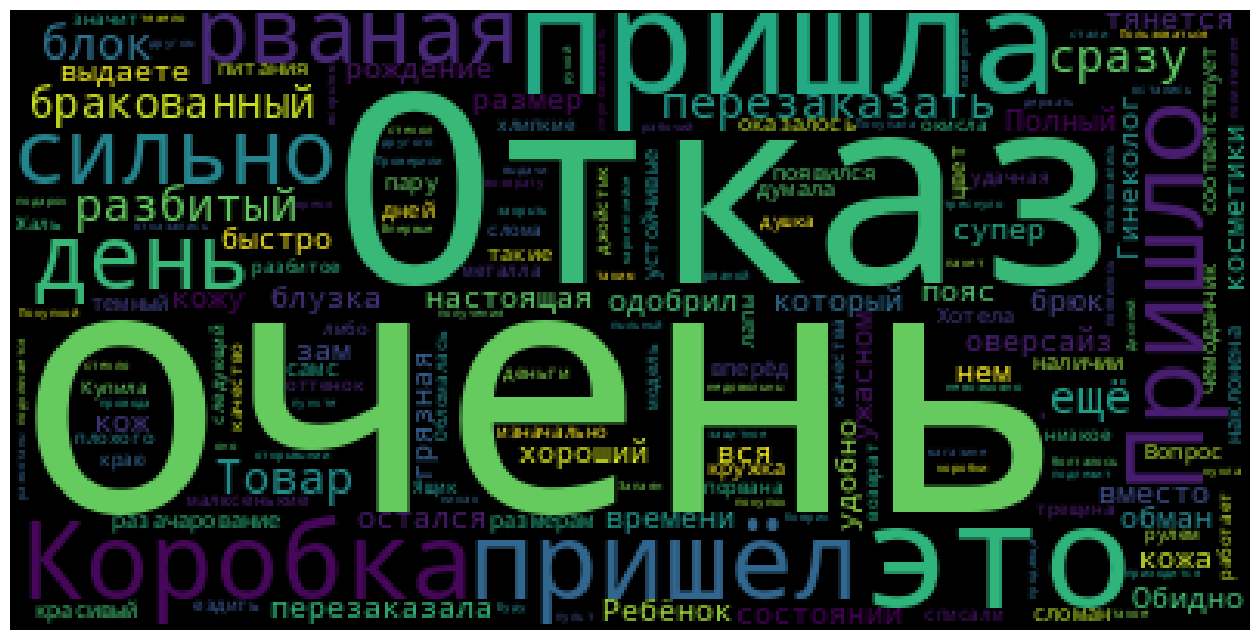

In [38]:
# Облако слов для отрицательных отзывов
text_data = ' '.join(df_to_pred[df_to_pred['sentiment'] == 0]['review'])
make_word_cloud(text_data, stop_words=stopwords)

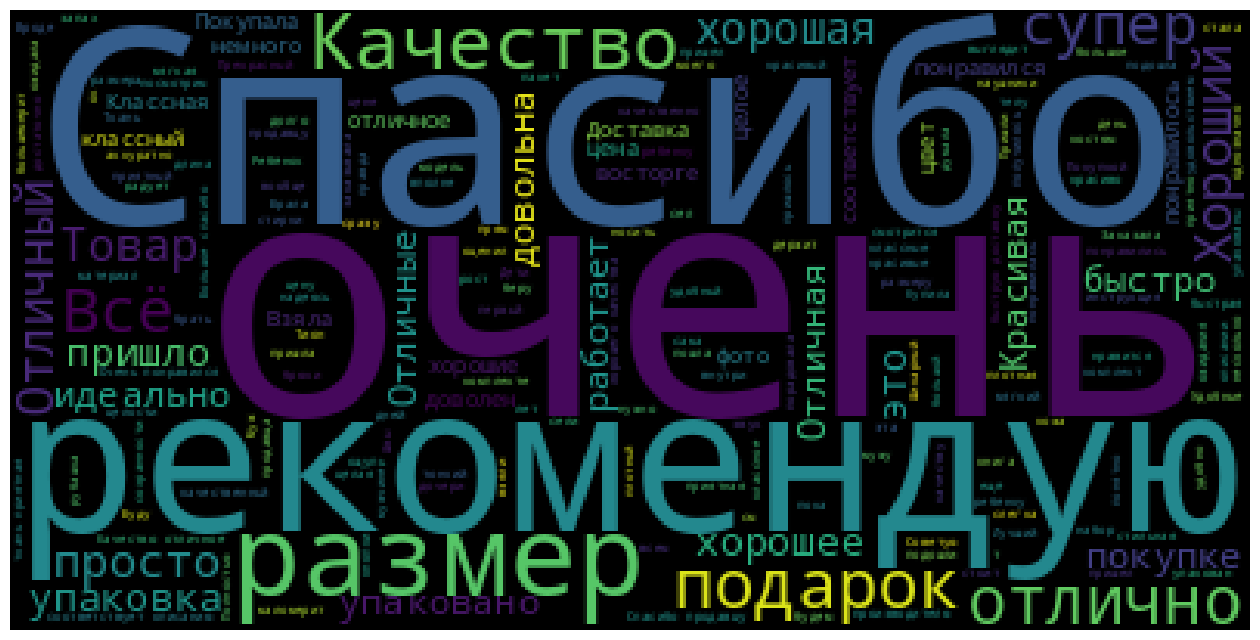

In [39]:
# Облако слов для положительных отзывов
text_data = ' '.join(df_to_pred[df_to_pred['sentiment'] == 2]['review'])
make_word_cloud(text_data, stop_words=stopwords)

## Препроцессинг данных

На этапе обучения и оценки моделей все манипуляции проводятся с данными из обучающего датасета

In [53]:
texts = np.array(df['review'])
labels = np.array(df['sentiment'])

In [54]:
def load_pretrained_vectors(word2idx, ft_model):
    """Load pretrained vectors and create embedding layers.

    Args:
        word2idx (Dict): словарь из корпуса текстов
        ft_model (CompressedFastTextKeyedVectors): Compressed FastText model

    Returns:
        embeddings (np.array): матрица мбеддингов размером (N, d),
        где N -размер словаря word2idx,  d - размерность эмбеддинга
    """

    print("Loading pretrained vectors...")

    # Инициализация эмбеддингов случайными числами
    d = ft_model.vector_size
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Загрузка предобученных векторов
    count = 0
    for word in tqdm(word2idx.keys()):
        if word in ft_model:
            count += 1
            embeddings[word2idx[word]] = ft_model[word]

    print(f"Найдено {count} / {len(word2idx)} предобученных векторов.")

    return embeddings

In [55]:
def tokenize(texts: list[str]) -> tuple[list[list[str]], dict, int]:
    """Токенизация текста, создание словаря, поиск максимальной длины последовательности токенов.

    Args:
        texts (List[str]): список текстов

    Returns:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Добавляем токены <pad> and <unk> к словарю
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Создаем словарь из корпуса, начиная с индекса 2
    idx = 2
    for sent in tqdm(texts):
        tokenized_sent = word_tokenize(sent)

        # Добавляем токенизированное предложение к списку ( тексту)
        tokenized_texts.append(tokenized_sent)

        # Добавляем новы токен к словарю `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # ВЫчисляем новое значение `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [56]:
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)

Tokenizing...



  0%|          | 0/90000 [00:00<?, ?it/s]

In [57]:
tokenized_texts[0]

['Качество',
 'свитера',
 'хорошее',
 ',',
 'но',
 'вот',
 'РАЗМЕР',
 '?',
 '?',
 '?',
 'Не',
 'соответствует',
 'совершенно',
 '.',
 'Заказывала',
 'себе',
 'свитер',
 'размером',
 'XL',
 ',',
 'а',
 'прислали',
 'свитер',
 'маленький',
 'не',
 'больше',
 'М.',
 'Объем',
 'свитера',
 'в',
 'груди',
 '90',
 'см',
 ',',
 'это',
 'явно',
 'не',
 'XL',
 '!',
 '!',
 '!',
 'Да',
 ',',
 'ещё',
 'на',
 'самом',
 'свитере',
 'не',
 'пришита',
 'бирка',
 'с',
 'размером',
 ',',
 'она',
 'просто',
 'вложена',
 'в',
 'пакет',
 'и',
 'где',
 'гарантия',
 ',',
 'что',
 'продавец',
 'отправил',
 'мне',
 'XL',
 ',',
 'а',
 'не',
 'другой',
 'размер',
 '.',
 'В',
 'общем',
 'свитер',
 'мне',
 'не',
 'подошел',
 ',',
 'жалею',
 'что',
 'не',
 'открыла',
 'спор',
 '.']

In [58]:
def encode(tokenized_texts, word2idx, max_len) -> np.array(int):
    """Добавляем в каждое предложение токены <PAD> до достижения длины max_length,
    кодируем токены их индексом в словаре.

    Args:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    Returns:
        input_ids (np.array): Массив индексов токенов размерностью (N, max_len).
        Будет подаваться на вход модели"""

    input_ids = []
    for tokenized_sent in tqdm(tokenized_texts):
        # Паддинг предложения до max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Кодироване токенов индексами input_ids из словаря word2idx
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

In [61]:
import os
import urllib.request
from pathlib import Path

In [63]:
# Путь для сохранения модели
model_path = '/kaggle/working/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'
# URL для загрузки модели
model_url = 'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'

# Если модель еще не загружена, загрузить ее
if not os.path.exists(model_path):
    print("Downloading model...")
    urllib.request.urlretrieve(model_url, model_path)
    print("Model downloaded successfully.")


In [ ]:
import compress_fasttext

In [ ]:

# Загрузить модель из файла
ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(model_path)

ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'
)

In [44]:
embeddings = load_pretrained_vectors(word2idx, ft)
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


  0%|          | 0/88444 [00:00<?, ?it/s]

Найдено 88444 / 88444 предобученных векторов.


In [72]:
input_ids = encode(tokenized_texts, word2idx, max_len)

  0%|          | 0/90000 [00:00<?, ?it/s]

# 3. Работа с моделями

## BaseLine: TFIDF

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
lr_model = LogisticRegression(solver='saga',penalty='l1', max_iter=300, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
y_pred = lr_model.predict(X_val_tfidf)
print(classification_report(y_pred, y_val, target_names =['negative', 'neautral', 'positive']))

## Модель CNN_NLP на базе сверточных слоев

### Разбиваем на train и val, загружаем в PyTorch DataLoader

In [73]:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]
batch_size = 50
num_classes = 3

In [74]:
def data_loader(train_inputs: np.array, val_inputs: np.array,
                train_labels: np.array, val_labels: np.array,
                batch_size: int) -> tuple[DataLoader, DataLoader]:
    """Преобразование обучающей и оценочной выборок в to torch.Tensors и загрузка в
    DataLoader.
    """

    # Преобразование в torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Создание DataLoader для train
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Создание DataLoader для val
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [75]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify=labels)
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=batch_size)

### Конструктор

In [76]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):
        """
        Args:
            pretrained_embedding (torch.Tensor): ПРедобученные эмбеддинги размерностью
                (vocab_size, embed_dim).Optional
            freeze_embedding (bool): Установить False при тонкой настройке предобученных эмбеддингов
                . Default: False
            vocab_size (int): необходимо задать, если не используются предобученные эмбеддинги.
            embed_dim (int): Размерность эмбеддинга. НЕобходимо задать, если не используются 
                предобученные эмбеддинги. Default: 300
            filter_sizes (List[int]): Список размеров фильтров. Default: [3, 4, 5]
            num_filters (List[int]): Список кол-ва филтров, той же длины, что и `filter_sizes`. 
                Default: [100, 100, 100]
            n_classes (int): Кол-во классов. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding Слой , куда подаютсяя эмбеддинги; они инициализируются случайным образом или загружаются уже предобученные
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Сверточные слои
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Полносвязный слой и Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Получаем эмбеддинги из `input_ids`. Размерность на выходе: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Переформатируем `x_embed` для соотвествия размерности `nn.Conv1d`.
        # Размерность на выходе: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Слои CNN and ReLU. Размерность на выходе: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Размерность на выходе: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Конкатенация x_pool_list для заполнения полносвязного слоя.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Вычисление логитов Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

### Модуль для  инициализации модели

In [77]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):
    """Инициализация модели и оптимизатора."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)

    cnn_model.to(device)

    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### модули для обучения и оценки модели

In [78]:
# задаем функцию потерь
loss_fn = nn.CrossEntropyLoss()

In [79]:
def set_seed(seed_value=42):
    """Устанавливаем seed для генератора псевдослучайных числе."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [80]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in tqdm(range(epochs)):
        # =======================================
        #               Training
        # =======================================

        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:

            val_loss, val_accuracy = evaluate(model, val_dataloader)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Best accuracy: {best_accuracy:.2f}%.")

In [81]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [82]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


### Вариант 1: Случайная инициализация векторов слов

In [ ]:
# CNN-rand
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.1,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=10)

### Вариант 2 - Используются compressed fastText эмбеддинги, которые замораживаются на период обучения

In [ ]:
# CNN-static
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=10)

### Вариант 3: Тонкая настройка compressed fastText эмбеддингов в процессе обучения модели

In [ ]:
# CNN-non-static
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.1,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=10)

### Вариант 4: используются предобученные эмбеддинги, полученные из модели seara/rubert-tiny2-russian-sentiment

In [83]:
# возвращается усредненный эмбеддинг для каждого предложения в батче
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #Первый элемент model_output содержит эмбеддинги всех токенов
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [84]:
texts[:2].tolist()

['Качество свитера хорошее, но вот РАЗМЕР???  Не соответствует совершенно.\r\nЗаказывала себе свитер размером XL, а прислали свитер маленький не больше М. \r\nОбъем свитера в груди 90 см, это явно не XL!!!  Да, ещё на самом свитере не пришита бирка с размером, она просто вложена в пакет и где гарантия, что продавец отправил мне XL, а не другой размер. В общем свитер мне не подошел, жалею что не открыла спор.',
 'оказался маленький \r\nкак майка']

In [ ]:
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-russian-sentiment")
model = AutoModel.from_pretrained("seara/rubert-tiny2-russian-sentiment")

#Tokenize sentences

encoded_input = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=24, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [86]:
sentence_embeddings[0]

tensor([ 2.2427e-01,  6.3447e-02,  4.2741e-01, -7.8177e-01, -2.1277e-01,
        -1.3931e-01, -5.1992e-01, -8.1573e-01, -8.2647e-01,  8.3118e-01,
         2.3828e-01,  5.4477e-01, -1.2408e-01,  1.3647e+00, -2.9276e-01,
         1.3343e-01,  8.6431e-01,  1.6036e-01, -1.1620e-01, -5.1693e-01,
        -1.0372e-01,  4.8854e-01, -2.5457e-01, -9.9276e-02,  8.5414e-01,
         2.2352e-01, -6.9961e-01,  2.8101e-01,  5.2546e-01, -2.6423e-01,
         3.9840e-01,  3.5526e-01, -8.7437e-01, -7.8546e-01,  1.0293e-01,
         1.1303e-01,  6.4817e-01,  1.2645e-01, -4.3304e-01,  1.6156e-01,
        -4.0862e-01, -7.8195e-01, -3.2697e-01,  5.1289e-01, -8.2168e-02,
        -2.8064e-01,  1.0842e-01, -1.0942e-01, -8.0364e-01, -5.6680e-01,
         1.2873e-01, -5.1673e-01,  5.7444e-01, -3.1584e-01,  2.6347e-01,
        -3.7458e-01,  9.7315e-01,  3.4919e-02, -8.4457e-01,  5.0687e-01,
         2.5129e-01,  1.2046e-01, -2.5114e-01, -8.8171e-01, -1.1650e-01,
        -8.9739e-01, -3.6565e-01, -2.4395e-03, -3.4

In [87]:
# CNN-seara
set_seed(42)
cnn_seara, optimizer = initilize_model(pretrained_embedding=sentence_embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_seara, optimizer, train_dataloader, val_dataloader, epochs=10)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.897521   |  0.778153  |   64.21   |   16.50  
   3    |   0.744581   |  0.703287  |   67.76   |   15.65  
   4    |   0.716077   |  0.700633  |   68.53   |   16.03  
   5    |   0.697754   |  0.673784  |   69.94   |   16.39  
   6    |   0.680058   |  0.668135  |   69.74   |   16.70  
   7    |   0.670071   |  0.661460  |   70.54   |   17.18  
   8    |   0.659444   |  0.656868  |   70.38   |   17.05  
   9    |   0.645922   |  0.666943  |   70.41   |   16.77  
  10    |   0.636267   |  0.684985  |   70.04   |   16.69  


Best accuracy: 70.54%.


val_accuracy в модели 3 незначительно выше, чем в baseline и моделях 1 и 2. Однако затраты врмени на обучение почти в 5 раз выше! Оптимальным вариантом является модель 2

### Прогнозирование
Получим classification_report для оценочного датасета, чтобы сравнить с baseline.
Затем проверим качество на Inference - открытом датасете с huggingface:
[TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset](https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset)

In [89]:
def predict(text, model=cnn_seara.to("cpu"), max_len=62, flag=False):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    if flag:
        print(f"This review is  {probs[0] * 100:.2f}% negative, {probs[1] * 100:.2f}% neutral & {probs[2] * 100:.2f}% positive.")
    return np.argmax(probs.detach().numpy())

In [ ]:
model_list = []
model_list.append(("CNN-rand", cnn_rand))
model_list.append(("CNN-static", cnn_static))
model_list.append(("CNN-non-static", cnn_non_static))
model_list.append(("CNN-seara", cnn_sbert))

In [90]:
train_t,val_t, train_l, val_l = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

In [91]:
predictions = []
for text, label in zip(val_t, val_l):
        predictions.append(predict(text, model= cnn_seara.to("cpu"), max_len=24, flag=False))
print('-----CNN-seara--------')
print(classification_report(np.array(predictions),val_l, target_names=['negative', 'neutral', 'positive']))
print()

-----CNN-seara--------
              precision    recall  f1-score   support

    negative       0.66      0.72      0.69      5452
     neutral       0.73      0.55      0.63      7958
    positive       0.70      0.91      0.79      4590

    accuracy                           0.70     18000
   macro avg       0.70      0.73      0.70     18000
weighted avg       0.70      0.70      0.69     18000




In [ ]:
# Получим classification_report для обучающего датасета, чтобы сравнить с baseline.
for name, model in model_list:
    predictions = []
    for text, label in zip(val_t, val_l):
        predictions.append(predict(text, model= model.to("cpu"), max_len=256, flag=False))
    print(f'-----{name}--------')
    print(classification_report(np.array(predictions),val_l, target_names=['negative', 'neutral', 'positive']))
    print()

In [25]:
# Проверим качество на Inference - открытом датасете с huggingface
# texts_to_pred = np.array(df_to_pred['review'])
labels_to_pred = np.array(df_to_pred['sentiment'])

In [26]:
texts_to_pred[0], labels_to_pred[0]

('Качество  отличное, так же ,как и пошив. Все аккуратно. Рубашка очень понравилась. Закажу ещё в черном цвете',
 2)

In [ ]:
for name, model in model_list:
    predictions = []
    for text, label in zip(texts_to_pred, labels_to_pred):
        predictions.append(predict(text, model= model.to("cpu"), max_len=256, flag=False))
    print(f'-----{name}--------')
    print(classification_report(np.array(predictions),labels_to_pred, target_names=['negative', 'neutral', 'positive']))
    print()

In [94]:
predictions = []
for text, label in zip(texts_to_pred, labels_to_pred):
        predictions.append(predict(text, model= cnn_seara.to("cpu"), max_len=24, flag=False))
print('-----CNN-seara--------')
print(classification_report(np.array(predictions),labels_to_pred, target_names=['negative', 'neutral', 'positive']))
print()

-----CNN-seara--------
              precision    recall  f1-score   support

    negative       0.36      0.28      0.31        36
     neutral       0.88      0.06      0.12       226
    positive       0.57      1.00      0.72       289

    accuracy                           0.57       551
   macro avg       0.60      0.45      0.38       551
weighted avg       0.68      0.57      0.45       551




Получился интересный результат - качество прогноза на тестовом датасете выше с самой первой моделью. Видимо, причина в том, что эмбеддинги, на которых обучалась 2 и 3 модели, строились уже исходя из конкретного корпуса текста, который значиетльно меньше, чем корпус, на котором обучалась модель fasttext

## Fine-tuning предобученной модели distilbert с huggingface

In [ ]:
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        review = str(self.data.review[index])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.sentiment[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
# Создаем датасет и даталоадер
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=42)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

In [ ]:
inference_set = Triage(df_to_pred, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
# train_dataloader = DataLoader(training_set, **train_params)
# val_dataloader = DataLoader(testing_set, **test_params)
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
inference_params = {'batch_size':1,
                'shuffle': False,
                'num_workers': 0
                }
inference_loader = DataLoader(inference_set)

In [ ]:
# Добавляем drop out и dense layer к исходной модели distil bert (без головы).

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

In [ ]:
# Оптимизатор и функция потерь
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Функция для вычисления accuracy модели
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss = 0.; nb_tr_steps = 0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples +=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 5000 steps: {loss_step}")
                print(f"Validation Accuracy per 5000 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [ ]:
best_model = None
best_epoch = 0
best_accuracy = 0.
for epoch in range(EPOCHS):
    train(epoch)
    acc = valid(model, testing_loader)
    if acc > best_accuracy:
        best_accuracy = acc
        best_epoch = epoch
        best_model = model
print("Accuracy on test data = %0.2f%%" % best_accuracy)

In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

In [ ]:
output_model_file = '/kaggle/working/pytorch_distilbert_news.bin'
output_vocab_file = '/kaggle/working/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

In [ ]:
output_model_file = '/kaggle/working/best_distilbert_news.bin'
output_vocab_file = '/kaggle/working/best_vocab_distilbert_news.bin'

model_to_save = best_model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

## Inference

In [ ]:
def predict_distilbert(inference_dataloader, model):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in inference_dataloader:
            input_ids = batch['ids'].to('cpu')
            attention_mask = batch['mask'].to('cpu')
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [ ]:
predictions = predict_distilbert(inference_loader, model.to('cpu'))

In [ ]:
print(classification_report(predictions,df_to_pred['sentiment'], target_names=['negative', 'neautral', 'positive']))

# inference на предобученной модели с huggingface

In [36]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
model("Привет, ты мне нравишься!")

[{'label': 'positive', 'score': 0.939876914024353}]

In [27]:
MAX_LEN = 512
X = texts_to_pred
y = labels_to_pred

In [28]:
# нужно уменьшить длину в токенах до максимальной 512. 
# Т.к в пайплайне huggingfасе встроенный токенизатор, нужно обрезать тексты за пределами
truncated_texts_to_pred = [' '.join(text.split()[:512]) for text in texts_to_pred]

In [29]:
sent_dict ={'negative': 0, 'neutral':1, 'positive': 2}

In [37]:
predictions = [model(text)[0]['label'] for text in truncated_texts_to_pred]

In [41]:
predictions_ =[sent_dict[x] for x in predictions]

In [45]:
print(classification_report(np.array(predictions_),labels_to_pred, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.50      0.54      0.52        26
     neutral       0.62      0.12      0.20        83
    positive       0.87      1.00      0.93       442

    accuracy                           0.85       551
   macro avg       0.67      0.55      0.55       551
weighted avg       0.82      0.85      0.80       551



# Генерация ответов на отрицательные отзывы

In [64]:
! pip install openai

In [66]:
import openai
from openai import OpenAI

In [67]:
def get_responce(review):
    client = OpenAI()
    prompt = f"Напиши ответ на отзыв '{review}'.В ответе вырази понимание проблемы и сообщи о предпринимаемых мерах по устранению проблемы. Уложись в 3 предложения"
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
      ]
    )
    return response.choices[0].message.content

In [29]:
response.choices[0].message.content

'Мне очень жаль, что ваша посылка была потеряна, и я понимаю, как это может быть неприятно. Мы предпринимаем все возможные меры, чтобы найти вашу посылку и разрешить эту ситуацию. Пожалуйста, оставьте свои контактные данные, чтобы мы могли связаться с вами и предоставить дополнительную поддержку.'

In [69]:
negatives = df_to_pred[df_to_pred['sentiment']==0].values
len(negatives)

28

In [73]:
for i, review in tqdm(enumerate(negatives)):
    print(f'{i}: Отзыв: {review} \n Ответ: {get_responce(review)}')

0it [00:00, ?it/s]

0: Отзыв: ['https://www.wildberries.ru/catalog/82017078/detail.aspx'
 'Пояс для беременных. / Бандаж для беременных 4 в 1 Послеродовой дородовой корсет'
 'Анастасия' '09 марта, 09:15' 0
 'Гинеколог не одобрил пояс, да и мне не очень удобно в нем' 0 1
 'Бандаж для беременных 4 в 1 Послеродовой дородовой корсет'
 'Пояс для беременных.' ''] 
 Ответ: Благодарим вас за отзыв и сожалеем, что гинеколог не одобрил использование пояса для беременных. Мы очень ценим ваше мнение и понимаем, что комфорт и безопасность для вас и вашего ребенка являются приоритетом. Мы принимаем во внимание вашу обратную связь и работаем над улучшением нашей продукции для удовлетворения потребностей всех наших клиентов.
1: Отзыв: ['https://www.wildberries.ru/catalog/44370466/detail.aspx'
 'Loungewear ZEFIRKA / Джемпер поло, женский джемпер теплый, кофта'
 'Ирина' '23 января, 21:04' 0
 'Очень сильно тянется, размер один, супер оверсайз, отказ' 0 0
 'Джемпер поло, женский джемпер теплый, кофта' 'Loungewear ZEFIRKA' ''

In [ ]:
responces[:5]